# Import des données et tokenisation

In [16]:
import os
import sys
import pandas as pd
import spacy
from multiprocessing import Pool, cpu_count
from pathlib import Path

# Charger le modèle spaCy pour le traitement du texte en français
nlp = spacy.load('fr_core_news_lg', disable=['parser', 'ner'])

def extractor(file_info):
    """ importer un fichier texte et en extraire des informations """

    def tokenizer_generator():
        """ générer des tokens à partir d'un document spaCy """
    
        for token in doc:
            if token.is_alpha and not token.like_num:
                if feature in {'text', 'lemma_', 'tag_', 'pos_', 'motifs'}:
                    if feature == 'motifs':
                        if token.pos_ not in {'NOUN', 'ADJ', 'VERB', 'PROPN'}:
                            yield token.text
                        else:
                            yield token.pos_
                    else:
                        yield getattr(token, feature)

            elif token.is_punct: 
                yield token.text
    
    file, max_len, feature, corpus_path = file_info
    genre, auteur, titre = file.stem.split('_')[:3] 

    with file.open() as f:
        texte = f.read()
        text_len = len(texte)
        if max_len is not None and max_len <= text_len:
            text_len = max_len
        nlp.max_length = text_len # modifie la taille limite de spaCy en fonction de la taille du texte

        doc = nlp(texte[0:text_len])  # Traiter le texte avec spaCy
        tokenized_text = ' '.join(tokenizer_generator())

        # Retourner les informations du fichier sous forme de dictionnaire
        return {'genre': genre, 'auteur': auteur[0:25], 'titre': titre.replace('.txt', '')[0:25],
                'size': text_len, 'texte': tokenized_text}

def import_parallel(corpus_path, max_len=None, feature='text'):
    """ Fonction principale pour importer en parallèle des fichiers à partir d'un répertoire """

    def generate_file_info(corpus_path, max_len, feature):
        """ générateur itératif sur répertoire """
    
        corpus_path = Path(corpus_path)
        for file in corpus_path.iterdir():
            yield (file, max_len, feature, corpus_path)

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(extractor, generate_file_info(corpus_path, max_len, feature))
    df = pd.DataFrame(results)
    return df

In [2]:
def Stopwords(file):
    """ Retourne une liste de stopwords français """
    with open(file, 'r') as f:
        stopwords=([d.strip() for d in f.readlines()])
    return stopwords

stopwords = Stopwords('data/stopwords--fr.txt')

# BOW

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer, StandardScaler

def bag_of_words(df_corpus, ngrams=[1,1]):
    """ Chaine de traitement Bag-of-words """
    pipeline = Pipeline([
        ('frequencer', TfidfVectorizer(use_idf=False, norm=None, ngram_range=ngrams)),
        ('normalizer', Normalizer(norm='l2')),
        ('standard_scaler', StandardScaler(with_mean=False)),
    ])
    matrice = pipeline.fit_transform(df_corpus.texte)
    df = pd.DataFrame(matrice.toarray()).T
    df.columns = df_corpus.titre
    inde = pipeline.named_steps['frequencer'].get_feature_names_out()

    df = df.set_index([inde], append=False)

    return df

def seuillage_bow(df_corpus, df_bow, n):
    """ thres pour forcer suppression de lignes à moins de thres valeur non nulle
        affiche le nombre de feature utilisés sur feature total 
    """ 
    non_zero_counts = df_bow.astype(bool).sum(axis=1)
    filtered_df_bow = df_bow[non_zero_counts > n]
    print(filtered_df_bow.shape[0],'/',df_bow.shape[0],'features')
    return filtered_df_bow

# VISUALISATION

### Dendrogramme

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA

def split_strings(strings_list, max_length=20):
    return [string[:max_length] for string in strings_list]

def dendro(df_corpus, df_bow, color_threshold):
    def calculate_positions(start, end, num_points):
        return np.linspace(start, end, num_points)

    def configure_twin_axis(ax, positions, labels, offset):
        ax_twin = ax.twiny()
        ax_twin.spines['top'].set_position(('outward', offset))
        ax_twin.set_xlim(ax.get_xlim())
        ax_twin.set_xticks(positions)
        ax_twin.set_xticklabels(labels, rotation=90, ha='center', fontsize=8)
        ax_twin.grid(False)

    distance_matrix = pdist(df_bow.T, metric='cosine')
    dist_matrix = linkage(distance_matrix, method='ward')

    clusters = fcluster(dist_matrix, t=color_threshold, criterion='distance')

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_bow.T)

    #scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='rainbow', s=30)
    #cov = pca.explained_variance_ratio_
    #plt.xlabel(f"Composante Principale 1: {cov[0]*100:.1f}%")
    #plt.ylabel(f"Composante Principale 2: {cov[1]*100:.1f}%")
    #plt.show()

    fig, ax = plt.subplots(figsize=(20, 8))

    dendro_trace = dendrogram(dist_matrix, leaf_font_size=5, color_threshold=color_threshold, ax=ax, above_threshold_color='black', orientation='bottom', labels=df_corpus.index)
    ax.set_xticks([])
    ax.set_position([0.1, 0.2, 0.7, 0.6])

    num_points = len(df_corpus)
    positions = calculate_positions(ax.get_xlim()[0] + 5, ax.get_xlim()[1] - 5, num_points)

    order_of_labels = dendro_trace['ivl']
    
    configure_twin_axis(ax, positions, split_strings(df_corpus.loc[order_of_labels]['genre'].tolist()), 0)
    configure_twin_axis(ax, positions, split_strings(df_corpus.loc[order_of_labels]['auteur'].tolist()), 85)
    configure_twin_axis(ax, positions, split_strings(df_corpus.loc[order_of_labels]['titre'].tolist()), 200)

    plt.tight_layout()
    plt.show()

### Analyse Composantes Principales + visualisation scatter

In [5]:
def ACP(df_corpus, df):
    
    df_binary = df.applymap(lambda x: 1 if x > 0 else 0)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df_binary.values.T)

    unique_genres = df_corpus.genre.unique()
    unique_auteurs = df_corpus.auteur.unique()

    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(9, 8))

    genre_color_palette = sns.color_palette("Set1", n_colors=len(unique_genres))
    author_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'H', '+', '|', '_', '<', '>']

    genre_handles = []
    genre_labels = []  # Liste pour stocker les noms des genres pour la légende
    for i, genre in enumerate(unique_genres):
        mask_genre = df_corpus.genre == genre
        genre_scatter = None
        genre_label = None  # Label personnalisé pour le genre
        for j, auteur in enumerate(unique_auteurs):
            mask = mask_genre & (df_corpus.auteur == auteur)
            genre_scatter = ax.scatter(
                X_pca[mask, 0],
                X_pca[mask, 1],
                color=genre_color_palette[i],
                marker=author_markers[j % len(author_markers)],
                s=80,
                alpha=0.9,
                label=f"{genre} - {auteur}"
                )
            genre_label = genre
            for k, (x, y, titre) in enumerate(zip(X_pca[mask, 0], X_pca[mask, 1], df_corpus[mask]["titre"])):
                ax.annotate(titre, (x, y), textcoords="offset points", xytext=(0,2), ha='left', fontsize=5)

        genre_handles.append(genre_scatter)
        genre_labels.append(genre_label)  # Ajouter le label personnalisé à la liste

    cov = pca.explained_variance_ratio_
    ax.set_xlabel(f"Composante Principale 1 ({cov[0]*100:.1f}%)")
    ax.set_ylabel(f"Composante Principale 2 ({cov[1]*100:.1f}%)")
    ax.grid(True, linestyle='--', alpha=0.5)

    # Légende pour les couleurs de genres avec les labels personnalisés
    a1 = ax.legend(handles=genre_handles, labels=genre_labels, title="Genres", loc='lower right')

    # Légende pour les auteurs avec marqueurs noirs
    author_legend_handles = [plt.Line2D([0], [0], marker=author_markers[i % len(author_markers)], color='black', label=auteur, markersize=10) for i, auteur in enumerate(unique_auteurs)]
    a2 = ax.legend(handles=author_legend_handles, title="Auteurs", loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

    # Ajouter la légende des genres à la légende des auteurs
    ax.add_artist(a1)

    # Créer une légende combinée pour les genres et les auteurs
    combined_handles = genre_handles + author_legend_handles
    combined_labels = genre_labels + [auteur for auteur in unique_auteurs]
    a_combined = plt.legend(handles=combined_handles, labels=combined_labels, title="Genres et Auteurs", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, handler_map={tuple: HandlerTuple(ndivide=None)})

    # Ajouter la légende combinée au graphique
    ax.add_artist(a_combined)

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------
#
# Main code
#
# -----------------------------------------------------------------

In [17]:
df_corpus = import_parallel('data/genre_sum/', feature='motifs') #genre_sum_2restreint
display(df_corpus)

,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,"PROPN PROPN La NOUN , pour quoi VERB ? NOUN VE..."
1,pamphlet,Chirac,Les rois de la République,517633,NOUN PROPN LES NOUN DE LA NOUN NOUN DES NOUN A...
2,essai,Bloy,Le Sang du pauvre,167171,"Le NOUN du NOUN PROPN PROPN PROPN , PROPN et P..."
3,essai,Péguy,Note sur M. Bergson et la,505412,"ET LA NOUN NOUN NOUN de PROPN . Ce NOUN , ( NO..."
4,essai,Daudet,Les Œuvres dans les homme,375229,PROPN PROPN LES NOUN DANS LES NOUN NOUN DES NO...
...,...,...,...,...,...
196,roman,Barrès,La Colline inspirée,479721,NOUN VERB DE PROPN NOUN LA NOUN PROPN … NOUN P...
197,pamphlet,Chirac,Les pots de vin parlement,54192,"LES PROPN Il y VERB plus de NOUN ADJ ou VERB ,..."
198,roman,Céline,Voyage au bout de la nuit,1055151,PROPN NOUN au NOUN de la NOUN PROPN A PROPN PR...
199,essai,Daudet,Bréviaire du journalisme,350753,"À mes NOUN de NOUN ADJ , affectueusement , PRO..."


In [18]:
for index, row in df_corpus.iterrows():
    # Créez le nom du fichier en combinant les valeurs des colonnes 'genre', 'auteur' et 'titre'
    nom_fichier = f"data/genre-motifs/{row['genre']}_{row['auteur']}_{row['titre']}.txt"
    
    # Récupérez le contenu du texte de la colonne 'texte'
    contenu = row['texte']
    
    # Écrivez le contenu dans un fichier texte avec le nom spécifié
    with open(nom_fichier, 'w', encoding='utf-8') as fichier:
        fichier.write(contenu)

# Sac de mot

In [ ]:
bow = bag_of_words(df_corpus, ngrams=(8,8))

bow_ = seuillage_bow(df_corpus, bow, 5)
bow_.head()

#dendro(df_corpus, bow_, color_threshold=1.01) # 1.01
ACP(df_corpus, bow_)
#AFE(df_corpus, bow_, num_factors=2)

# Paires de genre

In [9]:
def create_sub_corpus(dataframe, genre):
    return dataframe[dataframe['genre'] == genre]

def combine_sub_corpora(sub_corpus_1, sub_corpus_2):
    return pd.concat([sub_corpus_1, sub_corpus_2], ignore_index=True)

def analyze_sub_corpus(sub_corpus, ngrams=(1, 6), threshold=5):
    bow_sub = bag_of_words(sub_corpus, ngrams=ngrams)
    bow_sub_ = seuillage_bow(sub_corpus, bow_sub, threshold)
    dendro(sub_corpus, bow_sub_, color_threshold=1.01)
    ACP(sub_corpus, bow_sub_)
    # AFE(sub_corpus, bow_sub_, num_factors=2)

chosen_genre = "pamphlet"  # Remplacez par le genre que vous choisissez

sub_corpus_chosen = create_sub_corpus(df_corpus, chosen_genre)
unique_genres = df_corpus['genre'].unique()

sub_corpora_pairs = {}
for other_genre in unique_genres:
    if other_genre != chosen_genre:
        sub_corpus_other = create_sub_corpus(df_corpus, other_genre)
        sub_corpus_pair = combine_sub_corpora(sub_corpus_chosen, sub_corpus_other)
        sub_corpora_pairs[(chosen_genre, other_genre)] = sub_corpus_pair

('pamphlet', 'essai') 

1383 / 2816392 features


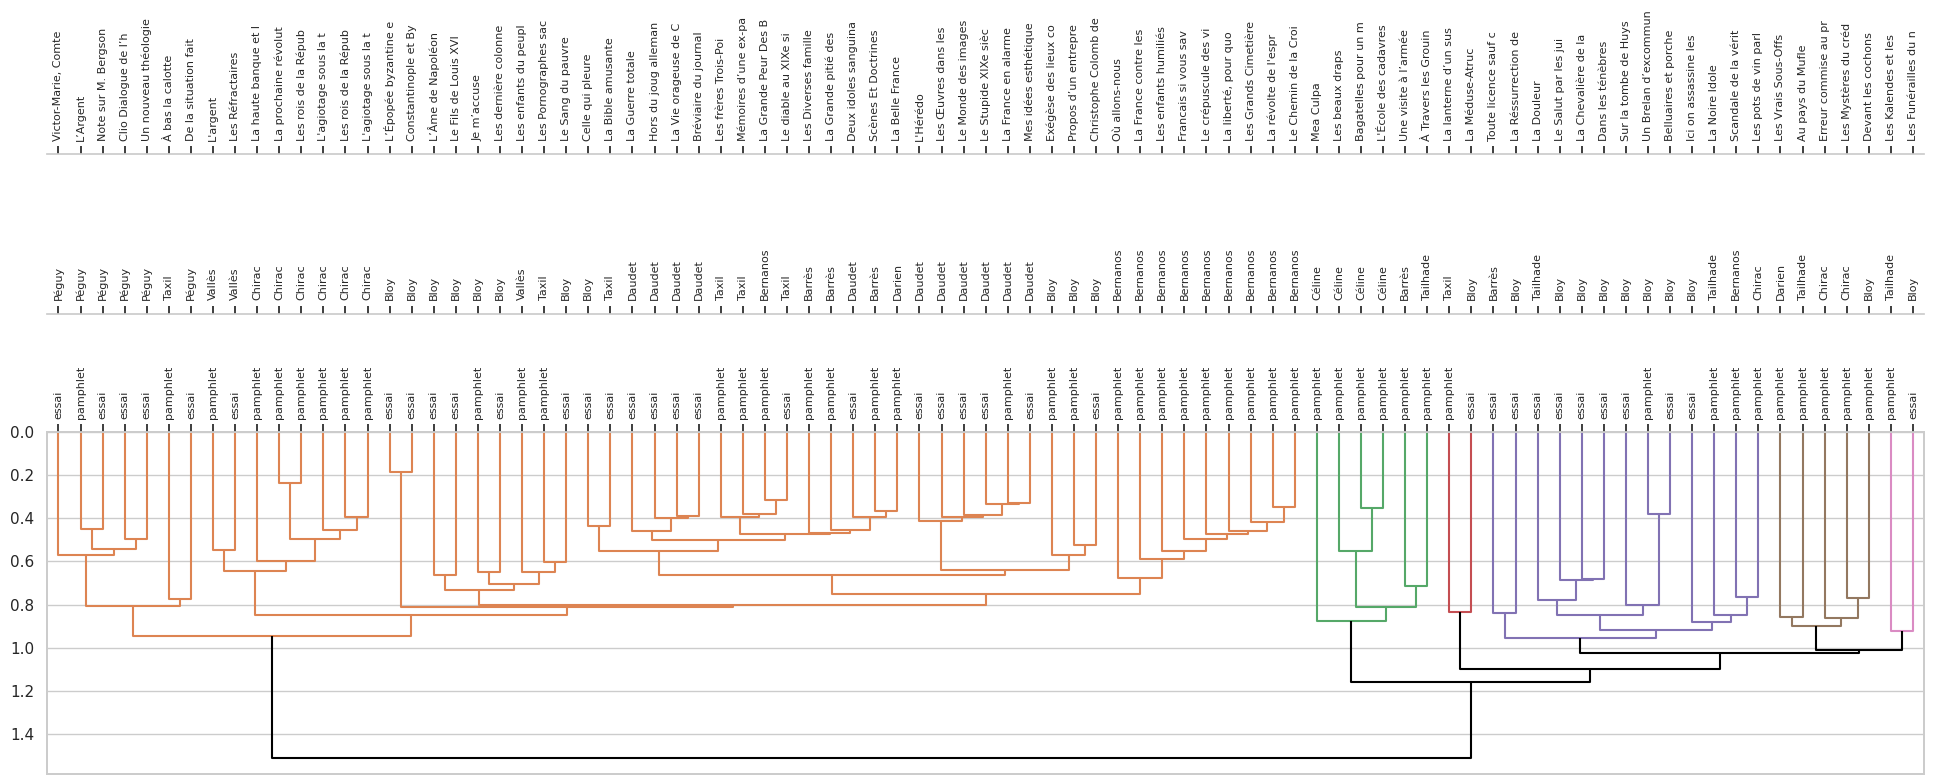

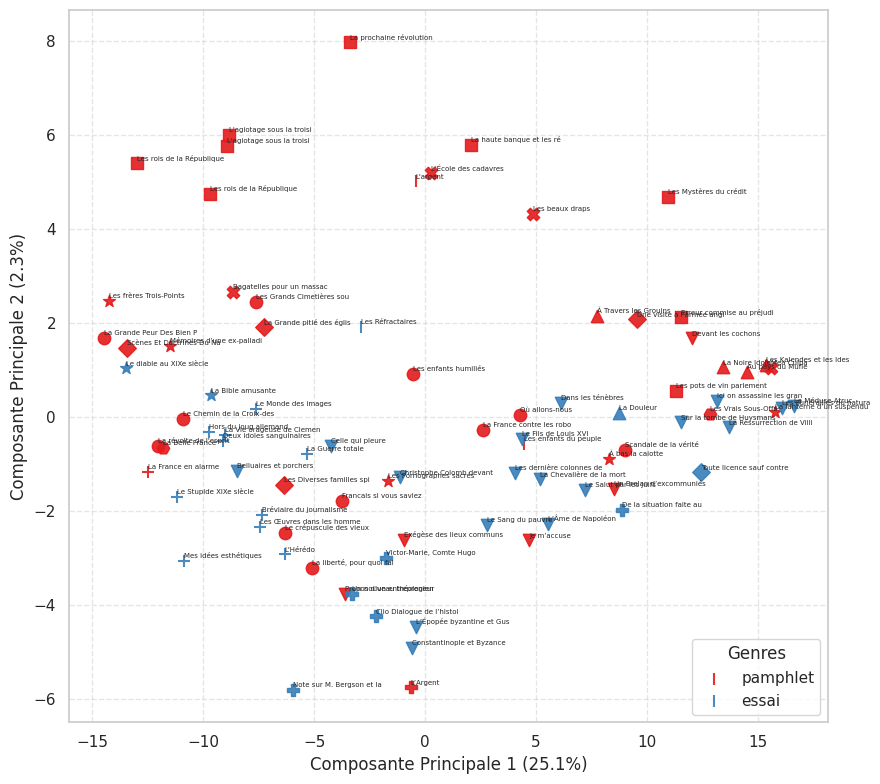

In [26]:
for genre_pair, sub_corpus_pair in sub_corpora_pairs.items():
    print(genre_pair,'\n')
    analyze_sub_corpus(sub_corpus_pair, ngrams=(6,6), threshold=30)
    break

('pamphlet', 'essai') 



,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,PROPN PROPN La NOUN pour quoi VERB NOUN VERB e...
1,pamphlet,Chirac,Les rois de la République,517633,AUGUSTE PROPN LES NOUN DE LA NOUN NOUN DES NOU...
2,pamphlet,Tailhade,Les Kalendes et les Ides,14747,Les PROPN et les NOUN PROPN PROPN La NOUN NOUN...
3,pamphlet,Barrès,Une visite à l’armée angl,88408,go NOUN NOUN NOUN ADJ Je avais pas VERB de ses...
4,pamphlet,Bloy,Je m’accuse,155284,Je VERB PROPN PROPN NOUN de La NOUN NOUN PROPN...
...,...,...,...,...,...
80,essai,Daudet,Mes idées esthétiques,434505,ADJ NOUN NOUN de la NOUN Ce qui VERB dans PROP...
81,essai,Daudet,Hors du joug allemand,426185,À NOUN de NOUN ADJ NOUN XIX est VERB par NOUN ...
82,essai,Bloy,Dans les ténèbres,128735,LE PROPN NOUN ADJ NOUN de la NOUN NOUN NOUN et...
83,essai,Bloy,Constantinople et Byzance,250795,i PROPN II LE NOUN DE NOUN NOUN ADJ VERB il NO...


11688 / 1845883 features


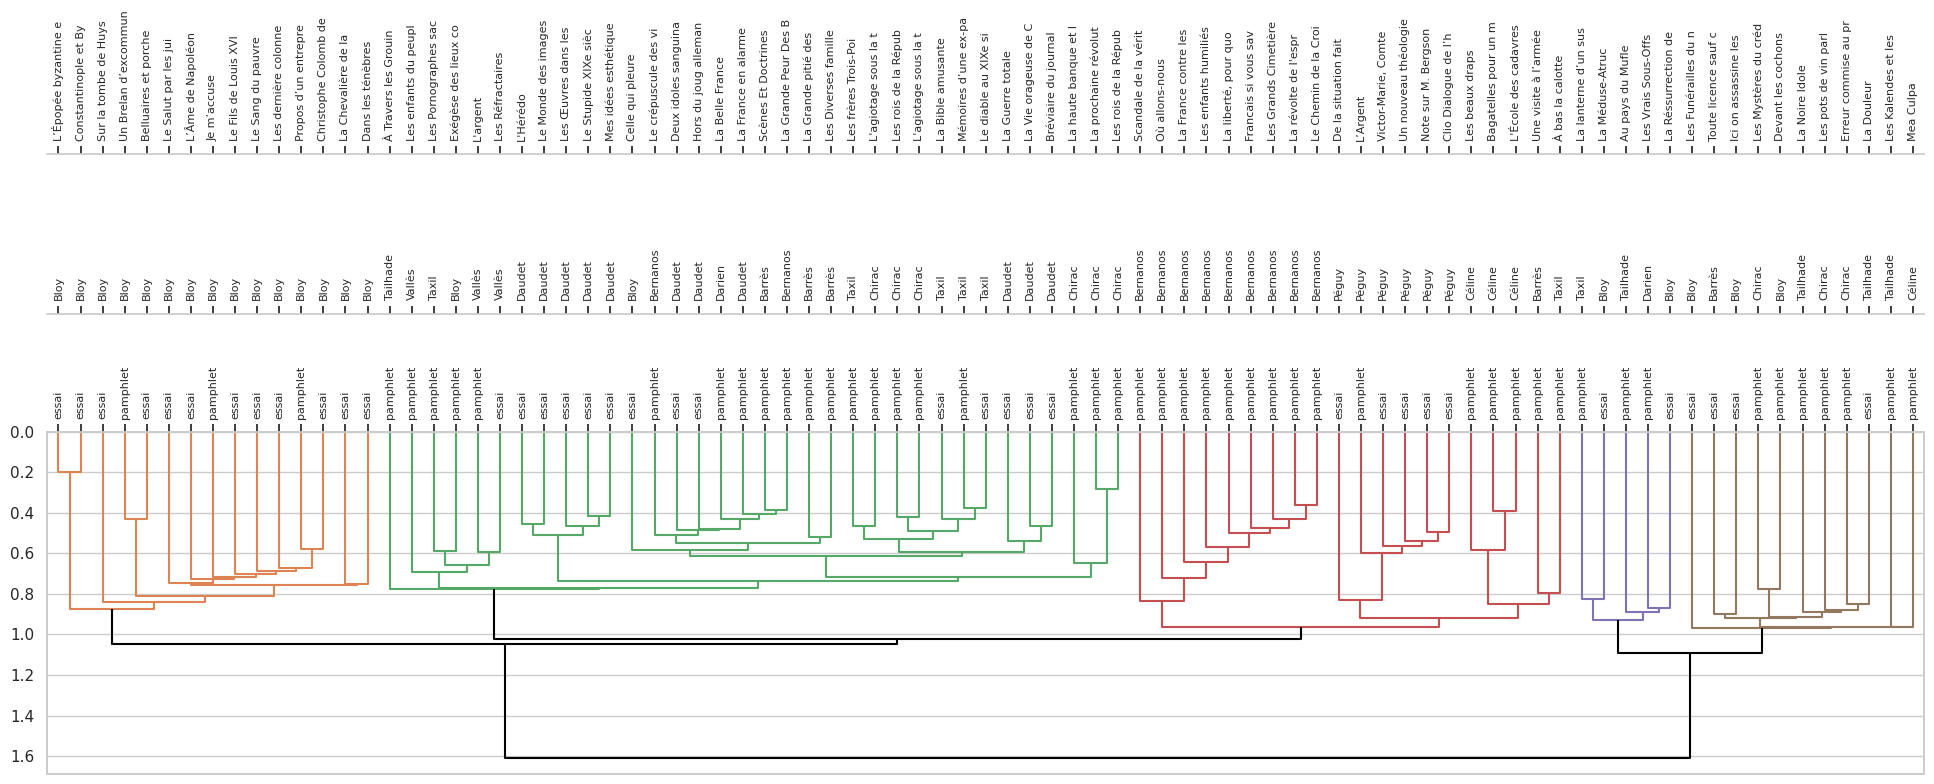

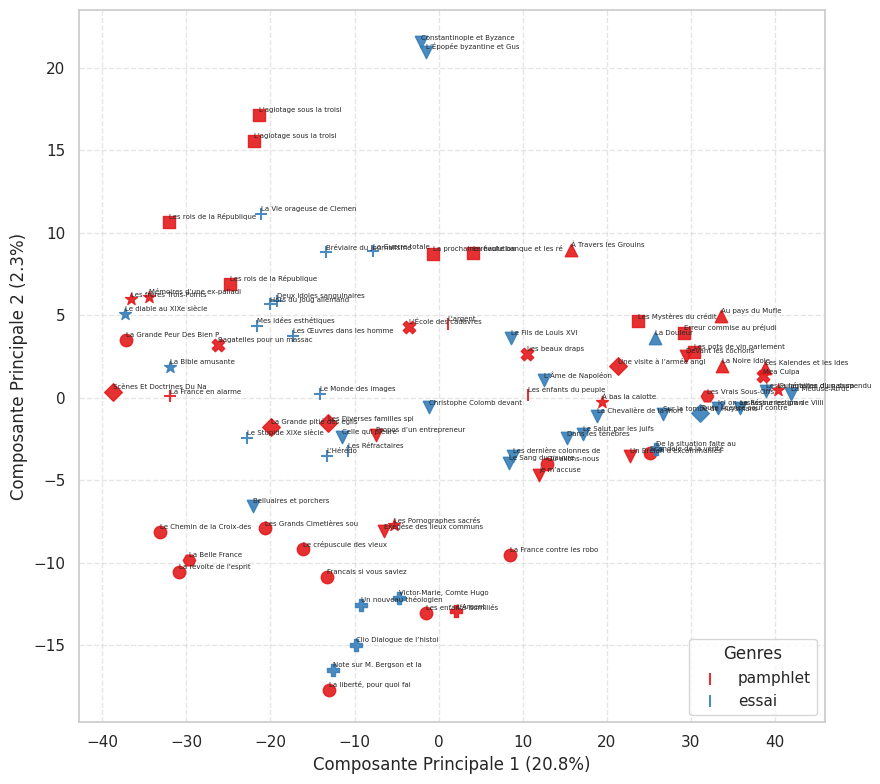

('pamphlet', 'roman') 



,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,PROPN PROPN La NOUN pour quoi VERB NOUN VERB e...
1,pamphlet,Chirac,Les rois de la République,517633,AUGUSTE PROPN LES NOUN DE LA NOUN NOUN DES NOU...
2,pamphlet,Tailhade,Les Kalendes et les Ides,14747,Les PROPN et les NOUN PROPN PROPN La NOUN NOUN...
3,pamphlet,Barrès,Une visite à l’armée angl,88408,go NOUN NOUN NOUN ADJ Je avais pas VERB de ses...
4,pamphlet,Bloy,Je m’accuse,155284,Je VERB PROPN PROPN NOUN de La NOUN NOUN PROPN...
...,...,...,...,...,...
106,roman,Barrès,Un voyage à Sparte,283037,NOUN à PROPN PROPN PROPN NOUN des NOUN PROPN V...
107,roman,Péguy,Notre Jeunesse,344387,Notre PROPN PROPN PROPN VERB de NOUN le NOUN N...
108,roman,Barrès,La Colline inspirée,479721,ADJ NOUN DE NOUN ADJ LA NOUN PROPN ADJ nemo NO...
109,roman,Céline,Voyage au bout de la nuit,800000,PROPN NOUN au NOUN de la NOUN PROPN A PROPN PR...


22829 / 2892533 features


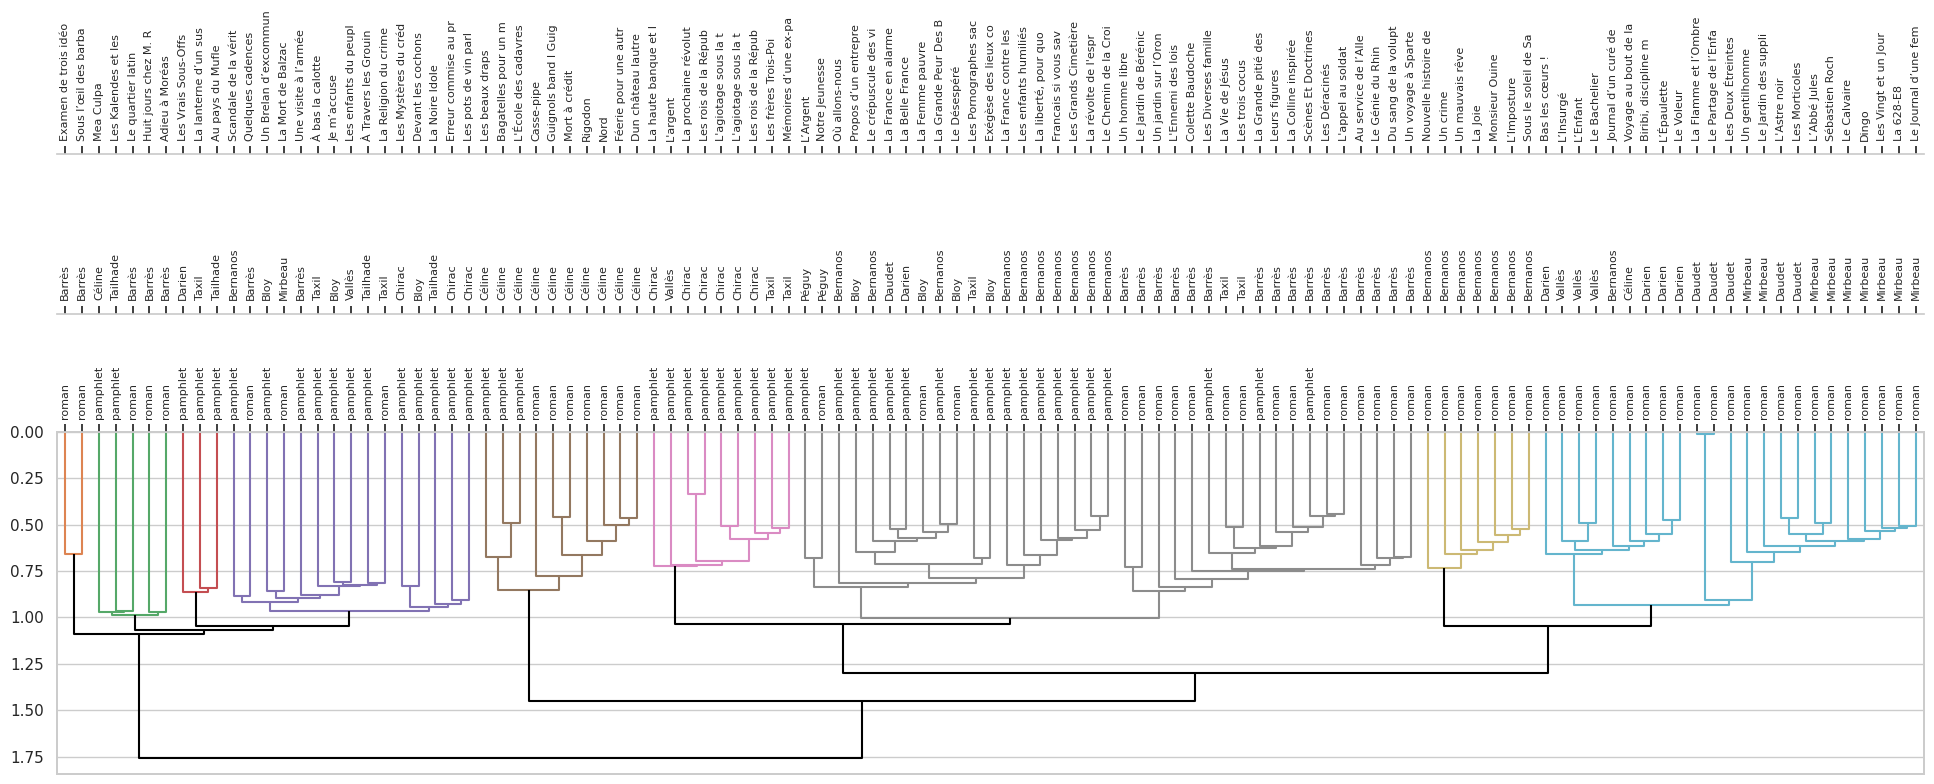

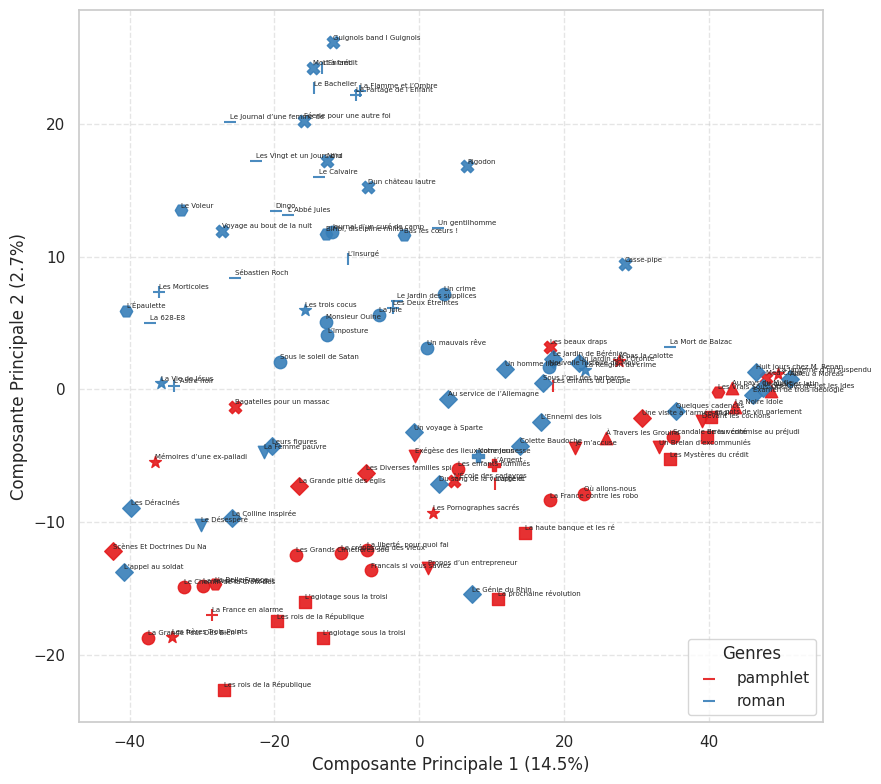

('pamphlet', 'article') 



,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,PROPN PROPN La NOUN pour quoi VERB NOUN VERB e...
1,pamphlet,Chirac,Les rois de la République,517633,AUGUSTE PROPN LES NOUN DE LA NOUN NOUN DES NOU...
2,pamphlet,Tailhade,Les Kalendes et les Ides,14747,Les PROPN et les NOUN PROPN PROPN La NOUN NOUN...
3,pamphlet,Barrès,Une visite à l’armée angl,88408,go NOUN NOUN NOUN ADJ Je avais pas VERB de ses...
4,pamphlet,Bloy,Je m’accuse,155284,Je VERB PROPN PROPN NOUN de La NOUN NOUN PROPN...
...,...,...,...,...,...
68,article,Mirbeau,Des artistes,59625,Des NOUN NOUN NOUN et NOUN NOUN PROPN PROPN PR...
69,article,Barrès,Les tâches d’encre,86624,Je ne suis pas VERB que le NOUN NOUN ADJ se fa...
70,article,d’Axa,À Paterson,18388,À PROPN PROPN PROPN NOUN de la NOUN ADJ La NOU...
71,article,Tailhade,Discours pour la Paix,34418,NOUN pour la NOUN PROPN PROPN NOUN ADJ PROPN V...


6412 / 1378135 features


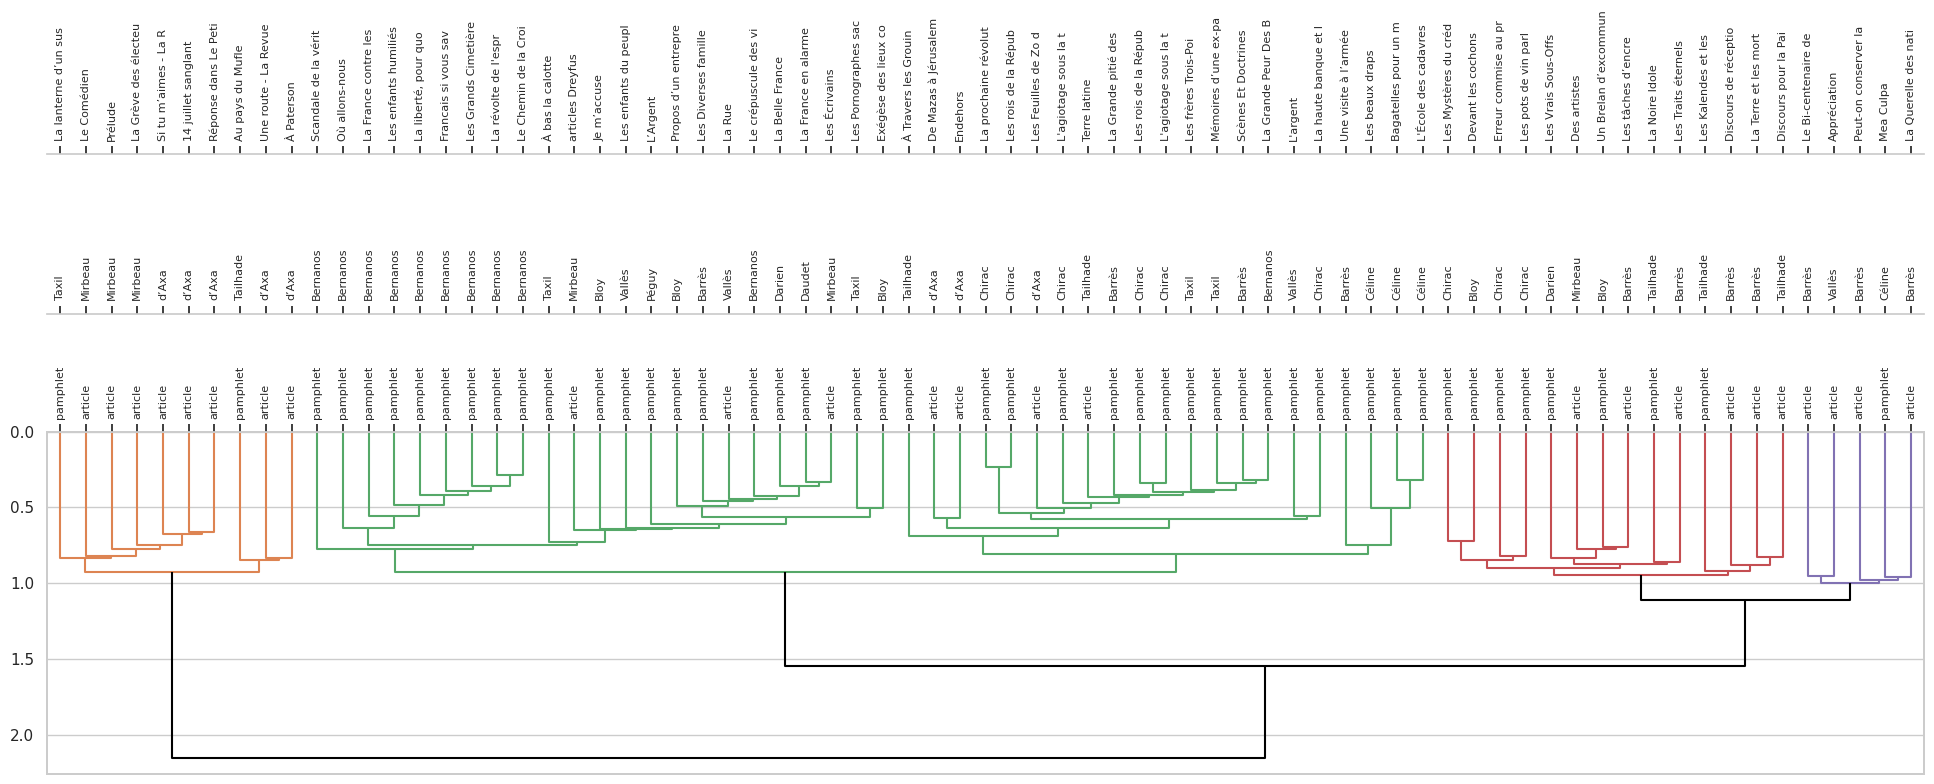

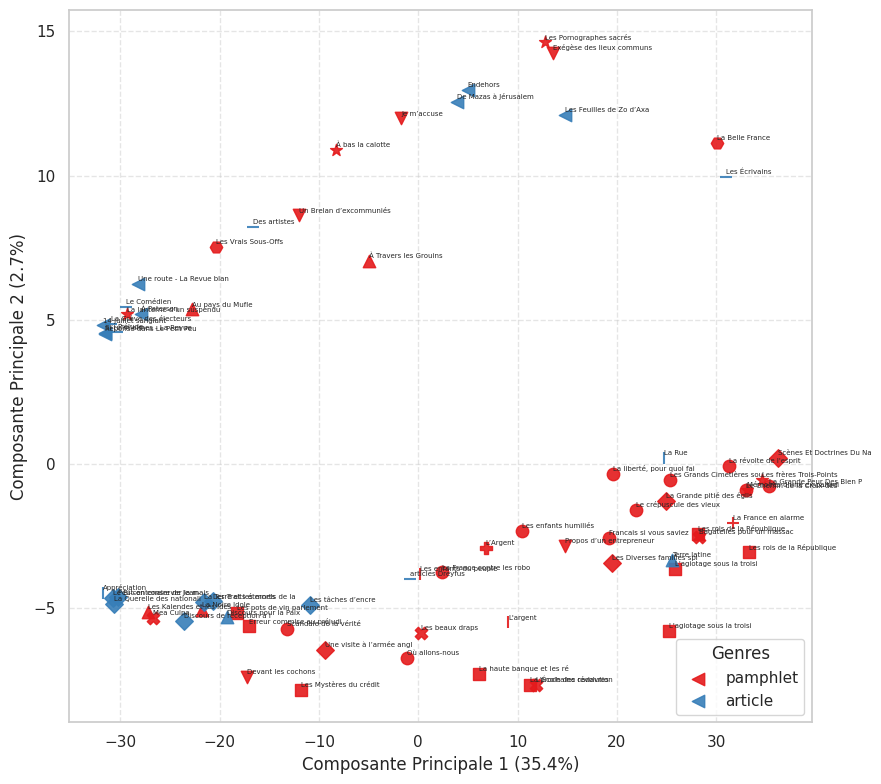

('pamphlet', 'mémoire et bio.') 



,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,PROPN PROPN La NOUN pour quoi VERB NOUN VERB e...
1,pamphlet,Chirac,Les rois de la République,517633,AUGUSTE PROPN LES NOUN DE LA NOUN NOUN DES NOU...
2,pamphlet,Tailhade,Les Kalendes et les Ides,14747,Les PROPN et les NOUN PROPN PROPN La NOUN NOUN...
3,pamphlet,Barrès,Une visite à l’armée angl,88408,go NOUN NOUN NOUN ADJ Je avais pas VERB de ses...
4,pamphlet,Bloy,Je m’accuse,155284,Je VERB PROPN PROPN NOUN de La NOUN NOUN PROPN...
...,...,...,...,...,...
56,mémoire et bio.,Bloy,Le Pèlerin de l’Absolu,477928,NOUN NOUN lut jamais été ADJ dans nia NOUN Les...
57,mémoire et bio.,Bloy,Lettres à Pierre Termier,476436,PROPN NOUN NOUN de La PROPN PROPN ADJ NOUN PRO...
58,mémoire et bio.,Bloy,Lettres de jeunesse,143119,Pour moi VERB encore ce que PROPN VERB VERB de...
59,mémoire et bio.,Bloy,Quatres ans de captivité,290751,NOUN DE PROPN PROPN ne VERB pas nous VERB Cett...


7023 / 1519311 features


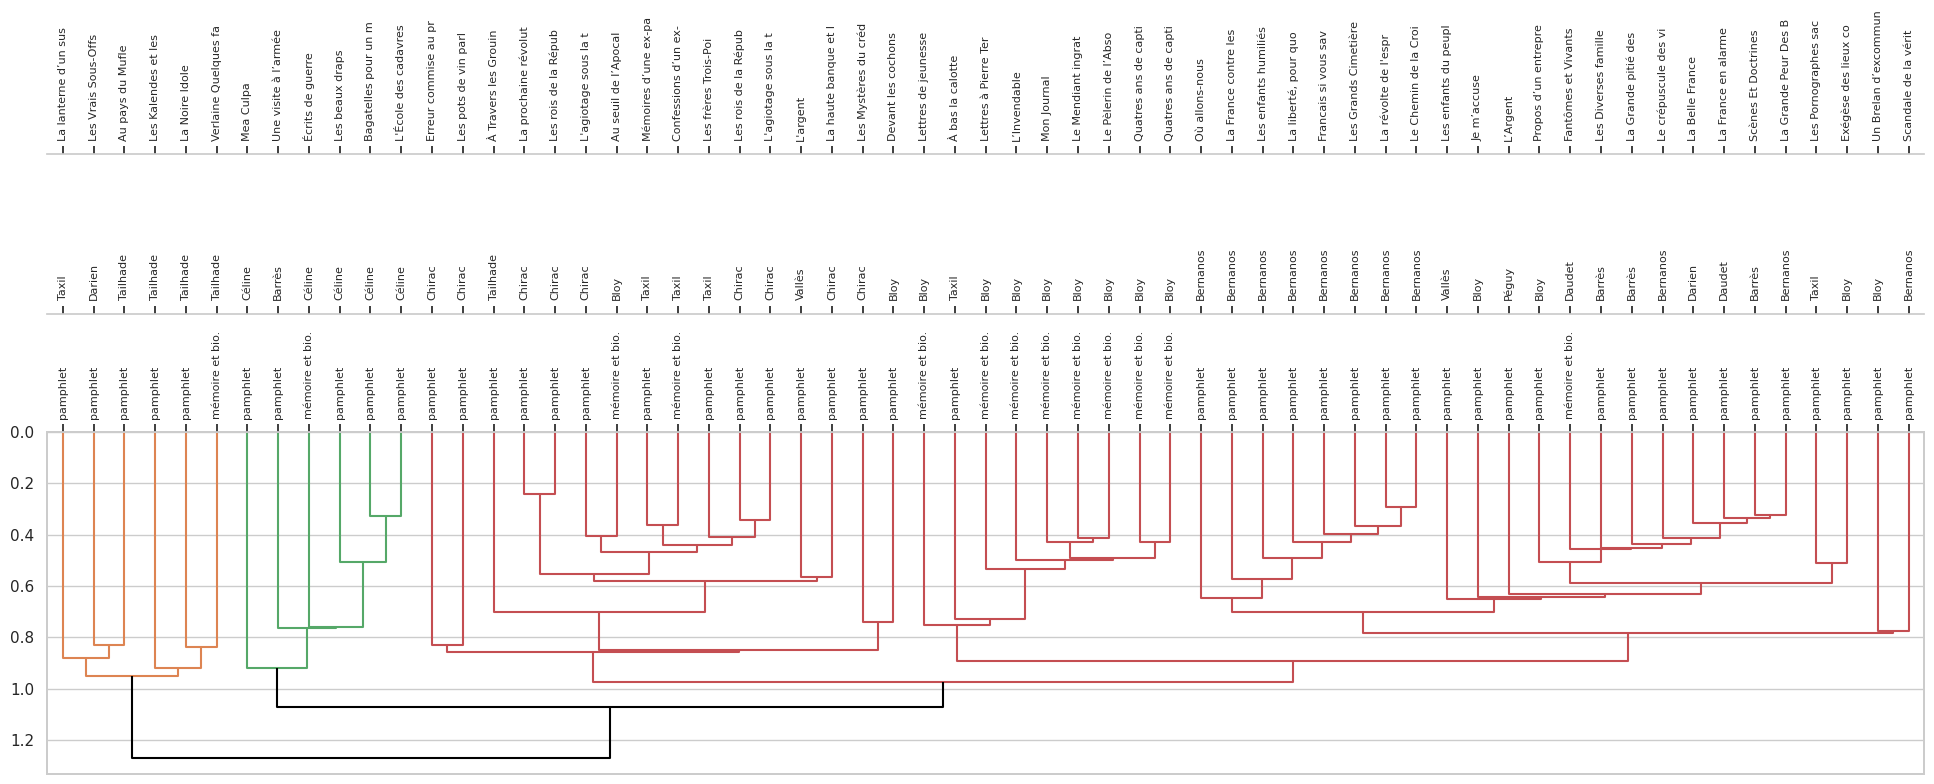

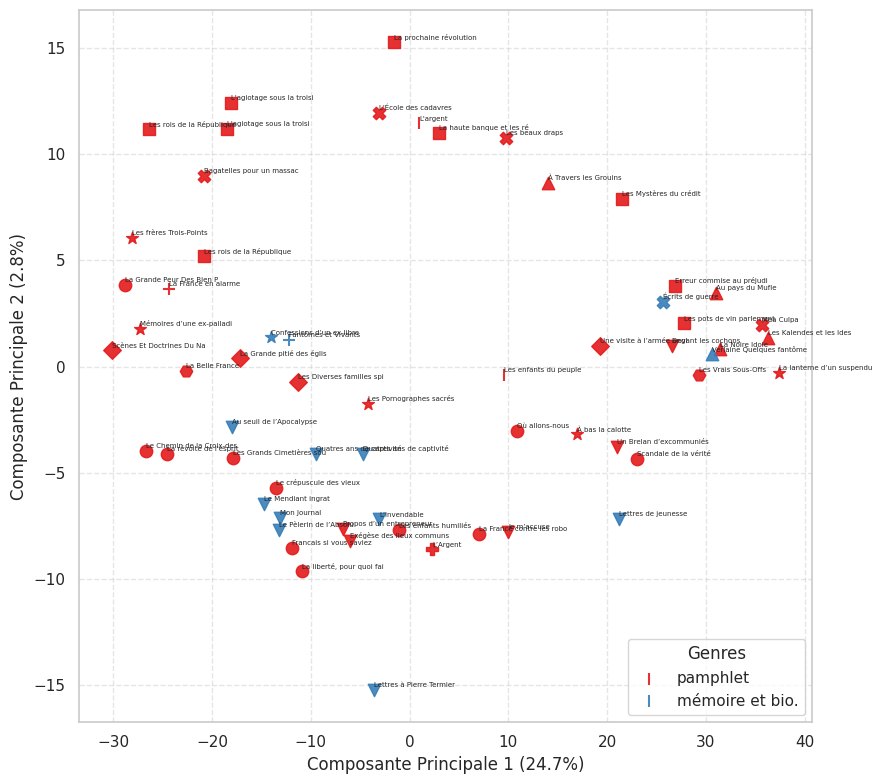

('pamphlet', 'nouvelle') 



,genre,auteur,titre,size,texte
0,pamphlet,Bernanos,"La liberté, pour quoi fai",424324,PROPN PROPN La NOUN pour quoi VERB NOUN VERB e...
1,pamphlet,Chirac,Les rois de la République,517633,AUGUSTE PROPN LES NOUN DE LA NOUN NOUN DES NOU...
2,pamphlet,Tailhade,Les Kalendes et les Ides,14747,Les PROPN et les NOUN PROPN PROPN La NOUN NOUN...
3,pamphlet,Barrès,Une visite à l’armée angl,88408,go NOUN NOUN NOUN ADJ Je avais pas VERB de ses...
4,pamphlet,Bloy,Je m’accuse,155284,Je VERB PROPN PROPN NOUN de La NOUN NOUN PROPN...
...,...,...,...,...,...
58,nouvelle,Barrès,Dialogues Parisiens,33295,PROPN Mon ADJ NOUN NOUN ADJ a VERB des NOUN de...
59,nouvelle,Bernanos,Écrits de jeunesse,72256,PROPN PROPN NOUN DE NOUN PROPN NOUN LA TOMBE N...
60,nouvelle,Mirbeau,Histoire d’une minute,12736,NOUN NOUN PROPN PROPN Le PROPN NOUN ADJ NOUN V...
61,nouvelle,Bloy,Histoires désobligeantes,319086,NOUN ADJ PROPN PROPN PROPN PROPN VERB de NOUN ...


6386 / 1435622 features


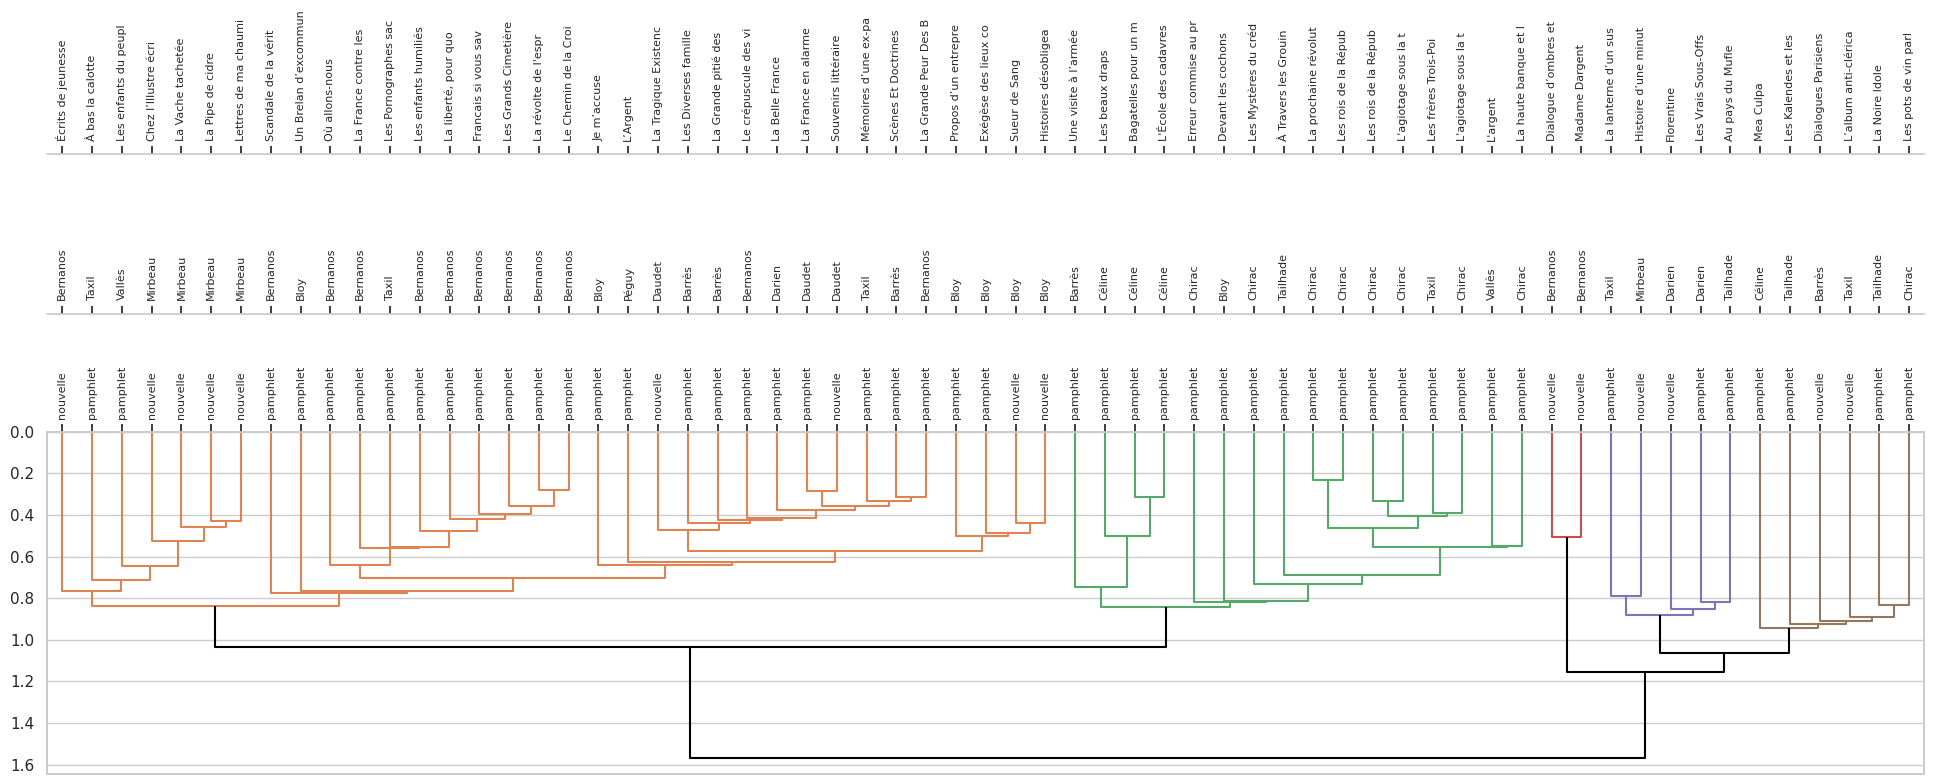

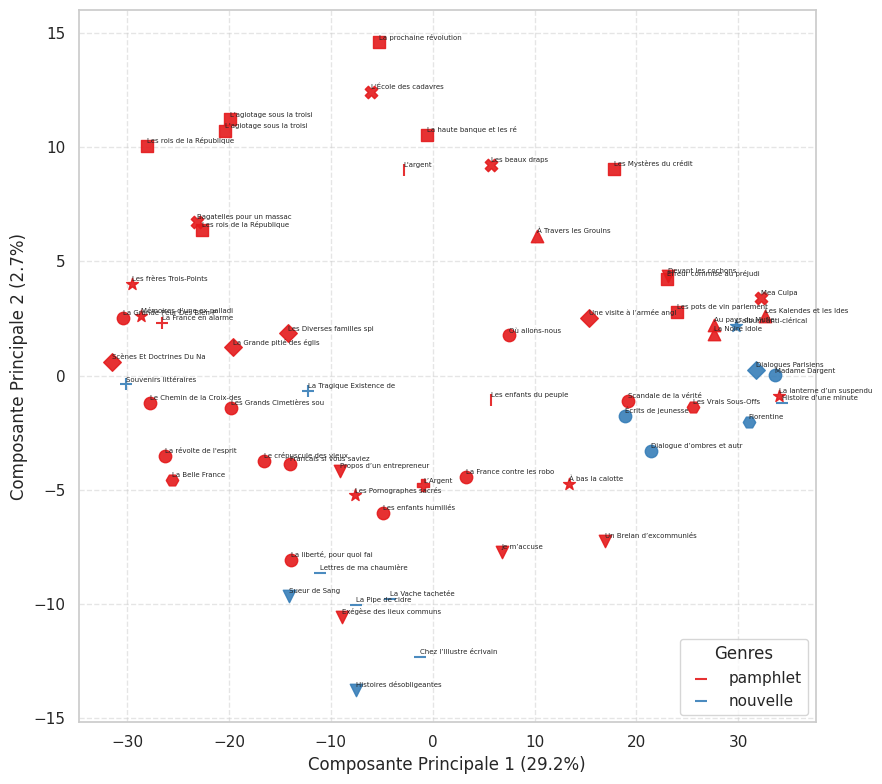

In [16]:
for genre_pair, sub_corpus_pair in sub_corpora_pairs.items():
    print(genre_pair,'\n')
    display(sub_corpus_pair)
    analyze_sub_corpus(sub_corpus_pair, ngrams=(5,5), threshold=20)